In [1]:
# Import packages
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn

In [2]:
# Define constants
seq_len = 100
valid_share = 0.4
min_response_val = 20 # (Arbitrary--based on simulated data)
max_response_val = 50 # (Arbitrary--based on simulated data)
torch.manual_seed(9999)
np.random.seed(9998)

In [3]:
# Specify directory/file paths
data_dir = "Data"

# sim_data_file = "DIBS_simulated_fmri_var4model.csv"
sim_data_file = "DIBS_simulated_fmri_VAR1_corr_model.csv"

In [4]:
# Check that CUDA GPUs are available
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f'Number of GPUs available: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i+1}: {torch.cuda.get_device_name(i)}')
else:
    device = torch.device("cpu")
    print("GPU not available--using CPU instead.")

Number of GPUs available: 1
GPU 1: NVIDIA TITAN Xp


In [5]:
# Load data
data = pd.read_csv(os.path.join(data_dir, sim_data_file), header=0)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,19.116246,16.565530,12.415547,18.299480,17.276543,15.754591,16.140283,16.699754,8.404268,11.854886,...,13.878511,6.417796,6.675971,12.511130,16.446791,15.229926,13.449784,10.026379,12.659897,16.061967
1,19.792518,19.305758,18.432122,19.598789,19.390565,19.234885,19.216070,19.378951,17.712553,18.576233,...,18.885059,17.471678,17.575436,18.570558,19.305121,18.991407,18.677850,18.059543,18.527432,19.265571
2,19.121983,19.876964,14.909188,18.882328,16.265094,16.886579,19.313189,14.342573,11.619733,14.133271,...,17.373623,9.282487,8.073071,12.552553,13.669796,14.597934,14.564002,11.974637,13.515495,16.382279
3,20.791987,20.660207,18.516190,22.940047,22.370048,19.327175,20.404752,18.564065,14.274104,17.026338,...,19.755899,16.347811,14.717065,14.199868,17.602043,16.879330,15.547040,13.652054,15.554164,20.579689
4,20.614162,16.734544,18.330194,23.063298,17.598805,19.865324,18.555408,18.876797,13.724560,15.565455,...,14.019824,10.375109,9.326729,11.398092,16.280734,18.053591,14.627125,13.729796,12.034983,18.283346


In [6]:
# Normalize data
data = (data - min_response_val)/(max_response_val - min_response_val)

In [7]:
# Shuffle data and create test dataset
shuffled_idx = np.random.permutation(len(data))
data = data.loc[shuffled_idx].reset_index(drop=True)

train_data = data.loc[0:int(len(data) * (1-valid_share)), ]
train_data.shape

test_idx = [idx for idx in data.index if idx not in train_data.index]
test_data = data.loc[test_idx, ]
print("Train data: ", train_data.shape, "\nTest data: ", test_data.shape)

Train data:  (31, 1000) 
Test data:  (19, 1000)


In [8]:
# Create input and target sequences for training data
train_input_seq = []
train_target_seq = []


for obs in range(len(train_data)):
    obs_data = train_data.iloc[obs]
    for i in range(len(obs_data) - seq_len):
        train_input_seq.append(obs_data[i:i+seq_len].values)
        train_target_seq.append(obs_data[i+seq_len])
        i += 1
print("# train input seqs: ", len(train_input_seq), "\n# train target seqs: ", len(train_target_seq))

# train input seqs:  27900 
# train target seqs:  27900


In [9]:
# Convert sequences to PyTorch tensors
train_input_tensor = torch.from_numpy(np.array(train_input_seq)).float().unsqueeze(-1)
train_input_tensor = train_input_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
train_input_tensor.shape

torch.Size([27900, 100, 1])

In [10]:
train_target_tensor = torch.from_numpy(np.array(train_target_seq)).float().unsqueeze(-1)
train_target_tensor = train_target_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
train_target_tensor.shape

torch.Size([27900, 1])

In [11]:
# Create RNN model class
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

        out, hidden = self.rnn(x, hidden)

        out = self.fc(out[:, -1, :])

        return out, hidden

In [12]:
# Instantiate model
input_size = 1
hidden_size = 64
output_size = 1

model = RNN(input_size, hidden_size, output_size, n_layers=1)
model.to(device)
model

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [14]:
# Train model
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output, hidden = model(train_input_tensor)
    # print(epoch, output.shape, train_target_tensor.shape, train_target_tensor.view(-1).shape)
    # print(epoch, hidden.shape)
    loss = criterion(output, train_target_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0073
Epoch [200/1000], Loss: 0.0068
Epoch [300/1000], Loss: 0.0067
Epoch [400/1000], Loss: 0.0067
Epoch [500/1000], Loss: 0.0067
Epoch [600/1000], Loss: 0.0067
Epoch [700/1000], Loss: 0.0067
Epoch [800/1000], Loss: 0.0067
Epoch [900/1000], Loss: 0.0067
Epoch [1000/1000], Loss: 0.0067


In [15]:
# Generate predicted values for training data
model.eval()
with torch.no_grad():
    train_predictions, _ = model(train_input_tensor)
train_predictions

tensor([[ 0.0796],
        [ 0.1891],
        [ 0.1472],
        ...,
        [-0.1230],
        [-0.1740],
        [-0.1416]], device='cuda:0')

In [16]:
# Compute MSE for training data
train_target_tensor = train_target_tensor.cpu()
train_predictions = train_predictions.cpu()

train_mse = (sum((train_target_tensor - train_predictions)**2))/len(train_predictions)
train_mse

tensor([0.0067])

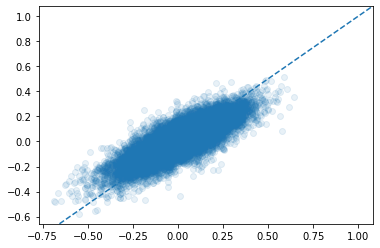

In [17]:
# Plot train predictions against actuals
fig, ax = plt.subplots()
ax.scatter(
    x=train_target_tensor.cpu(),
    y=train_predictions.cpu(),
    alpha=0.1
)
ax.axline([0, 0], [1, 1], linestyle="--")

In [18]:
# Create input and target sequences for test data
test_input_seq = []
test_target_seq = []

for obs in range(len(test_data)):
    obs_data = test_data.iloc[obs]
    for i in range(len(obs_data) - seq_len):
        test_input_seq.append(obs_data[i:i+seq_len].values)
        test_target_seq.append(obs_data[i+seq_len])
        i += 1
print("# test input seqs: ", len(test_input_seq), "\n# test target seqs: ", len(test_target_seq))

# test input seqs:  17100 
# test target seqs:  17100


In [19]:
# Convert test sequences to PyTorch tensors
test_input_tensor = torch.from_numpy(np.array(test_input_seq)).float().unsqueeze(-1)
test_input_tensor = test_input_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
test_input_tensor.shape

torch.Size([17100, 100, 1])

In [20]:
test_target_tensor = torch.from_numpy(np.array(test_target_seq)).float().unsqueeze(-1)
test_target_tensor = test_target_tensor.to(device) # Note that "to" method for tensors is not in-place operation (like it is for nn.Module/model below)
test_target_tensor.shape

torch.Size([17100, 1])

In [21]:
# Generate predictions for test data
model.eval()
with torch.no_grad():
    test_predictions, _ = model(test_input_tensor)
test_predictions

tensor([[ 0.2804],
        [ 0.4215],
        [ 0.2900],
        ...,
        [-0.1110],
        [-0.1394],
        [-0.1524]], device='cuda:0')

In [22]:
# Compute MSE for test data
test_target_tensor = test_target_tensor.cpu()
test_predictions = test_predictions.cpu()

test_mse = (sum((test_target_tensor - test_predictions)**2))/len(test_predictions)
test_mse

tensor([0.0061])

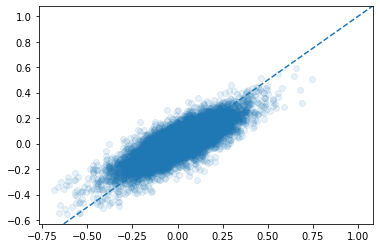

In [23]:
# Plot test predictions against actuals
fig, ax = plt.subplots()
ax.scatter(
    x=test_target_tensor.cpu(),
    y=test_predictions.cpu(),
    alpha=0.1
)
ax.axline([0, 0], [1, 1], linestyle="--")